In [1]:
import lightgbm
import numpy as np
import pandas as pd
from feature_engine.datetime import DatetimeFeatures
from lightgbm import LGBMClassifier
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from src.column_data_frame_transformer import ColumnDataFrameTransformer
from src.column_selector import ColumnSelector
from src.date_coercion import DateCoercion
from src.encoder import OneHotDataFrameEncoder
from src.high_cardinality_dropper import HighCardinalityDroppper
from src.imputer import SimpleDataFrameImputer
from src.nan_dropper import NaNColumnsDropper
from src.replacer import Replacer
from src.scaler import StandardDataFrameScaler

## Load data set

In [2]:
car_insurance_df = pd.read_csv("./data/insurance_claims.csv")
car_insurance_df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [3]:
train_df, test_df = train_test_split(
    car_insurance_df, test_size=0.2, random_state=42, shuffle=True
)

In [4]:
train_df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
29,241,45,596785,2014-03-04,IL,500/1000,2000,1104.50,0,432211,...,NO,91650,14100,14100,63450,Accura,TL,2011,N,NaN
535,65,23,876699,1999-12-12,OH,250/500,1000,1099.95,0,473109,...,YES,52400,6550,6550,39300,Accura,MDX,2005,Y,NaN
695,289,45,943425,1999-10-28,OH,250/500,2000,1221.41,0,466289,...,NO,2700,300,300,2100,Honda,Accord,2006,N,NaN
557,63,26,550930,1995-10-12,IL,500/1000,500,1500.04,6000000,613826,...,YES,5160,860,860,3440,Accura,TL,2004,N,NaN
836,257,43,797636,1992-05-19,IN,100/300,1000,974.84,0,468984,...,YES,85320,21330,7110,56880,Nissan,Pathfinder,2006,N,NaN


# Columns sets

In [5]:
excluded = [
    "policy_number",
    "insured_hobbies",
    "policy_state",
    "incident_state",
    "incident_city",
    "insured_hobbies",
    "auto_make",
    "auto_model",
]
date_features = ["incident_date", "policy_bind_date"]
target_variable = ["fraud_reported"]

In [6]:
selected_columns = car_insurance_df.columns.difference(
    excluded + target_variable
).tolist()

selected_columns

['_c39',
 'age',
 'authorities_contacted',
 'auto_year',
 'bodily_injuries',
 'capital-gains',
 'capital-loss',
 'collision_type',
 'incident_date',
 'incident_hour_of_the_day',
 'incident_location',
 'incident_severity',
 'incident_type',
 'injury_claim',
 'insured_education_level',
 'insured_occupation',
 'insured_relationship',
 'insured_sex',
 'insured_zip',
 'months_as_customer',
 'number_of_vehicles_involved',
 'police_report_available',
 'policy_annual_premium',
 'policy_bind_date',
 'policy_csl',
 'policy_deductable',
 'property_claim',
 'property_damage',
 'total_claim_amount',
 'umbrella_limit',
 'vehicle_claim',
 'witnesses']

# Columns transformers

In [7]:
mapping_dict = dict(
    zip(selected_columns, [{"?": np.nan} for _ in selected_columns])
)
mapping_dict

{'_c39': {'?': nan},
 'age': {'?': nan},
 'authorities_contacted': {'?': nan},
 'auto_year': {'?': nan},
 'bodily_injuries': {'?': nan},
 'capital-gains': {'?': nan},
 'capital-loss': {'?': nan},
 'collision_type': {'?': nan},
 'incident_date': {'?': nan},
 'incident_hour_of_the_day': {'?': nan},
 'incident_location': {'?': nan},
 'incident_severity': {'?': nan},
 'incident_type': {'?': nan},
 'injury_claim': {'?': nan},
 'insured_education_level': {'?': nan},
 'insured_occupation': {'?': nan},
 'insured_relationship': {'?': nan},
 'insured_sex': {'?': nan},
 'insured_zip': {'?': nan},
 'months_as_customer': {'?': nan},
 'number_of_vehicles_involved': {'?': nan},
 'police_report_available': {'?': nan},
 'policy_annual_premium': {'?': nan},
 'policy_bind_date': {'?': nan},
 'policy_csl': {'?': nan},
 'policy_deductable': {'?': nan},
 'property_claim': {'?': nan},
 'property_damage': {'?': nan},
 'total_claim_amount': {'?': nan},
 'umbrella_limit': {'?': nan},
 'vehicle_claim': {'?': nan

In [8]:
nan_corrector = Replacer(mapper=mapping_dict)

In [9]:
column_selector = ColumnSelector(selected_columns=selected_columns)

In [10]:
date_coercion = DateCoercion(date_columns=date_features)

In [11]:
nan_column_dropper = NaNColumnsDropper(threshold=0.4)

In [12]:
# REVIEW
high_cardinality_droppper = HighCardinalityDroppper(
    threshold=0.9,
    exclude=date_features,
)

In [13]:
# REVIEW
date_featurizer = DatetimeFeatures(
    variables=date_features,
    features_to_extract=["month", "day_of_week", "day_of_month", "day_of_year"]
)

In [14]:
numeric_imputer = SimpleDataFrameImputer(strategy="median")

In [15]:
# REVIEW
categorical_imputer = SimpleDataFrameImputer(strategy="mode")

In [16]:
numeric_transformer = StandardDataFrameScaler()

In [17]:
one_hot_transformer = OneHotDataFrameEncoder(handle_unknown="ignore")

# Data preprocessing steps

In [18]:
data_cleaner = Pipeline(
    steps=[
        ("nan corrector", nan_corrector),
        ("business rules selector", column_selector),
        ("date coercion", date_coercion),
        ("nan column dropper", nan_column_dropper),
        ("high cadrdinality dropper", high_cardinality_droppper),
    ]
)

In [19]:
numeric_transformer = Pipeline(
    steps=[
        ("numerical_imputer", numeric_imputer),
        ("scaler", numeric_transformer),
    ]
)

In [20]:
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", categorical_imputer),
        ("OHE", one_hot_transformer),
    ]
)

In [21]:
column_transformer = ColumnDataFrameTransformer(
    transformers=[
        ("date_feature", date_featurizer, date_features),
        (
            "categorical_transformer",
            categorical_transformer,
            make_column_selector(dtype_include=object),
        ),
        (
            "numeric_transformer",
            numeric_transformer,
            make_column_selector(dtype_include=[np.float64, np.int64]),
        ),
    ],
)

In [22]:
preprocessor_tester = Pipeline(
    [
        ("cleaner", data_cleaner),
        ("column_transformer", column_transformer),
    ]
)

In [23]:
X_train = train_df.loc[:,train_df.columns.difference(target_variable)]
y_train = train_df.loc[:, target_variable].values.ravel()

X_test = test_df.loc[:,test_df.columns.difference(target_variable)]
y_test = test_df.loc[:, target_variable].values.ravel()

In [24]:
preprocessor_tester.fit(X_train)

Pipeline(steps=[('cleaner',
                 Pipeline(steps=[('nan corrector',
                                  Replacer(mapper={'_c39': {'?': nan},
                                                   'age': {'?': nan},
                                                   'authorities_contacted': {'?': nan},
                                                   'auto_year': {'?': nan},
                                                   'bodily_injuries': {'?': nan},
                                                   'capital-gains': {'?': nan},
                                                   'capital-loss': {'?': nan},
                                                   'collision_type': {'?': nan},
                                                   'incident_date': {'?': nan},
                                                   'incident_hour_of_the_day': {'?': nan},
                                                   'incident_locati...
                                                                            SimpleDataFrameImputer(strategy='most_frequent')),
                                                                           ('OHE',
                                                                            OneHotDataFrameEncoder(handle_unknown='ignore'))]),
                                                           <sklearn.compose._column_transformer.make_column_selector object at 0x14ecb8cd0>),
                                                          ('numeric_transformer',
                                                           Pipeline(steps=[('numerical_imputer',
                                                                            SimpleDataFrameImputer()),
                                                                           ('scaler',
                                                                            StandardDataFrameScaler())]),
                                                           <sklearn.compose._column_transformer.make_column_selector object at 0x14ecb8940>)]))])

In [25]:
output_df = preprocessor_tester.fit_transform(X_train)
output_df

,date_feature__incident_date_month,date_feature__incident_date_day_of_week,date_feature__incident_date_day_of_month,date_feature__incident_date_day_of_year,date_feature__policy_bind_date_month,date_feature__policy_bind_date_day_of_week,date_feature__policy_bind_date_day_of_month,date_feature__policy_bind_date_day_of_year,categorical_transformer__authorities_contacted_Ambulance,categorical_transformer__authorities_contacted_Fire,...,numeric_transformer__incident_hour_of_the_day,numeric_transformer__injury_claim,numeric_transformer__months_as_customer,numeric_transformer__number_of_vehicles_involved,numeric_transformer__policy_deductable,numeric_transformer__property_claim,numeric_transformer__total_claim_amount,numeric_transformer__umbrella_limit,numeric_transformer__vehicle_claim,numeric_transformer__witnesses
0,2.0,6.0,15.0,46.0,3.0,1.0,4.0,63.0,0.0,0.0,...,-0.949950,1.335925,0.301419,-0.804695,1.399911,1.375409,1.447362,-0.489302,1.327654,0.465374
1,1.0,3.0,15.0,15.0,12.0,6.0,12.0,346.0,0.0,0.0,...,0.336664,-0.199262,-1.243193,-0.804695,-0.230262,-0.189850,-0.033297,-0.489302,0.053450,-1.320234
2,2.0,4.0,27.0,58.0,10.0,3.0,28.0,301.0,0.0,0.0,...,-0.378122,-1.470111,0.722676,-0.804695,1.399911,-1.485594,-1.908170,-0.489302,-1.909299,-0.427430
3,2.0,4.0,13.0,44.0,10.0,3.0,12.0,285.0,0.0,0.0,...,-0.949950,-1.356243,-1.260745,-0.804695,-1.045349,-1.369495,-1.815370,2.060804,-1.838598,0.465374
4,2.0,3.0,26.0,57.0,5.0,1.0,19.0,140.0,0.0,0.0,...,-1.664736,2.806044,0.441838,-0.804695,-0.230262,-0.073751,1.208570,-0.489302,0.981007,-0.427430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.0,1.0,13.0,13.0,10.0,6.0,7.0,280.0,0.0,0.0,...,-0.806993,-0.178928,2.258511,1.170017,-0.230262,2.588225,1.000335,-0.489302,0.786843,0.465374
796,1.0,1.0,27.0,27.0,4.0,0.0,15.0,105.0,0.0,0.0,...,-0.806993,1.937799,1.424772,1.170017,1.399911,0.220642,1.207816,-0.489302,1.130324,-1.320234
797,2.0,4.0,6.0,37.0,11.0,1.0,16.0,321.0,0.0,0.0,...,0.193707,0.644583,0.204880,1.170017,-0.230262,0.670524,0.210021,-0.489302,-0.044160,0.465374
798,2.0,6.0,15.0,46.0,8.0,6.0,29.0,241.0,0.0,0.0,...,-0.806993,-0.038626,-0.918473,-0.804695,-1.045349,-0.026068,0.758902,-0.489302,1.078089,-1.320234


In [26]:
output_df.columns

Index(['date_feature__incident_date_month',
       'date_feature__incident_date_day_of_week',
       'date_feature__incident_date_day_of_month',
       'date_feature__incident_date_day_of_year',
       'date_feature__policy_bind_date_month',
       'date_feature__policy_bind_date_day_of_week',
       'date_feature__policy_bind_date_day_of_month',
       'date_feature__policy_bind_date_day_of_year',
       'categorical_transformer__authorities_contacted_Ambulance',
       'categorical_transformer__authorities_contacted_Fire',
       'categorical_transformer__authorities_contacted_None',
       'categorical_transformer__authorities_contacted_Other',
       'categorical_transformer__authorities_contacted_Police',
       'categorical_transformer__collision_type_Front Collision',
       'categorical_transformer__collision_type_Rear Collision',
       'categorical_transformer__collision_type_Side Collision',
       'categorical_transformer__incident_severity_Major Damage',
       'categorica

In [27]:
set(selected_columns).difference(output_df.columns)

{'_c39',
 'age',
 'authorities_contacted',
 'auto_year',
 'bodily_injuries',
 'capital-gains',
 'capital-loss',
 'collision_type',
 'incident_date',
 'incident_hour_of_the_day',
 'incident_location',
 'incident_severity',
 'incident_type',
 'injury_claim',
 'insured_education_level',
 'insured_occupation',
 'insured_relationship',
 'insured_sex',
 'insured_zip',
 'months_as_customer',
 'number_of_vehicles_involved',
 'police_report_available',
 'policy_annual_premium',
 'policy_bind_date',
 'policy_csl',
 'policy_deductable',
 'property_claim',
 'property_damage',
 'total_claim_amount',
 'umbrella_limit',
 'vehicle_claim',
 'witnesses'}

# Model

In [28]:
preprocessor = Pipeline(
    [
        ("cleaner", data_cleaner),
        ("column_transformer", column_transformer)
    ]
)

In [29]:
classifier = LGBMClassifier(
    class_weight="balanced",
    random_state=11,
    learning_rate=0.03,
    n_estimators=600,
    reg_lambda=0.19,
    reg_alpha=0.19,
)

In [30]:
model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", classifier),
    ]
)

In [31]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cleaner',
                                  Pipeline(steps=[('nan corrector',
                                                   Replacer(mapper={'_c39': {'?': nan},
                                                                    'age': {'?': nan},
                                                                    'authorities_contacted': {'?': nan},
                                                                    'auto_year': {'?': nan},
                                                                    'bodily_injuries': {'?': nan},
                                                                    'capital-gains': {'?': nan},
                                                                    'capital-loss': {'?': nan},
                                                                    'collision_type': {'?': nan},
                                                                    'incident_date': {'?': nan},
                                                                    'incident_hour_of_the...
                                                                            <sklearn.compose._column_transformer.make_column_selector object at 0x14ecb8cd0>),
                                                                           ('numeric_transformer',
                                                                            Pipeline(steps=[('numerical_imputer',
                                                                                             SimpleDataFrameImputer()),
                                                                                            ('scaler',
                                                                                             StandardDataFrameScaler())]),
                                                                            <sklearn.compose._column_transformer.make_column_selector object at 0x14ecb8940>)]))])),
                ('classifier',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.03,
                                n_estimators=600, random_state=11,
                                reg_alpha=0.19, reg_lambda=0.19))])

# Summary

In [32]:
y_test[:20]

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N',
       'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y'], dtype=object)

In [33]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [34]:
# Accuracy
round(model.score(X_test, y_test), 4)

0.77

In [35]:
# F1 score
from sklearn.metrics import f1_score

round(f1_score(model.predict(X_test), y_test, pos_label="Y"), 4)

0.5818

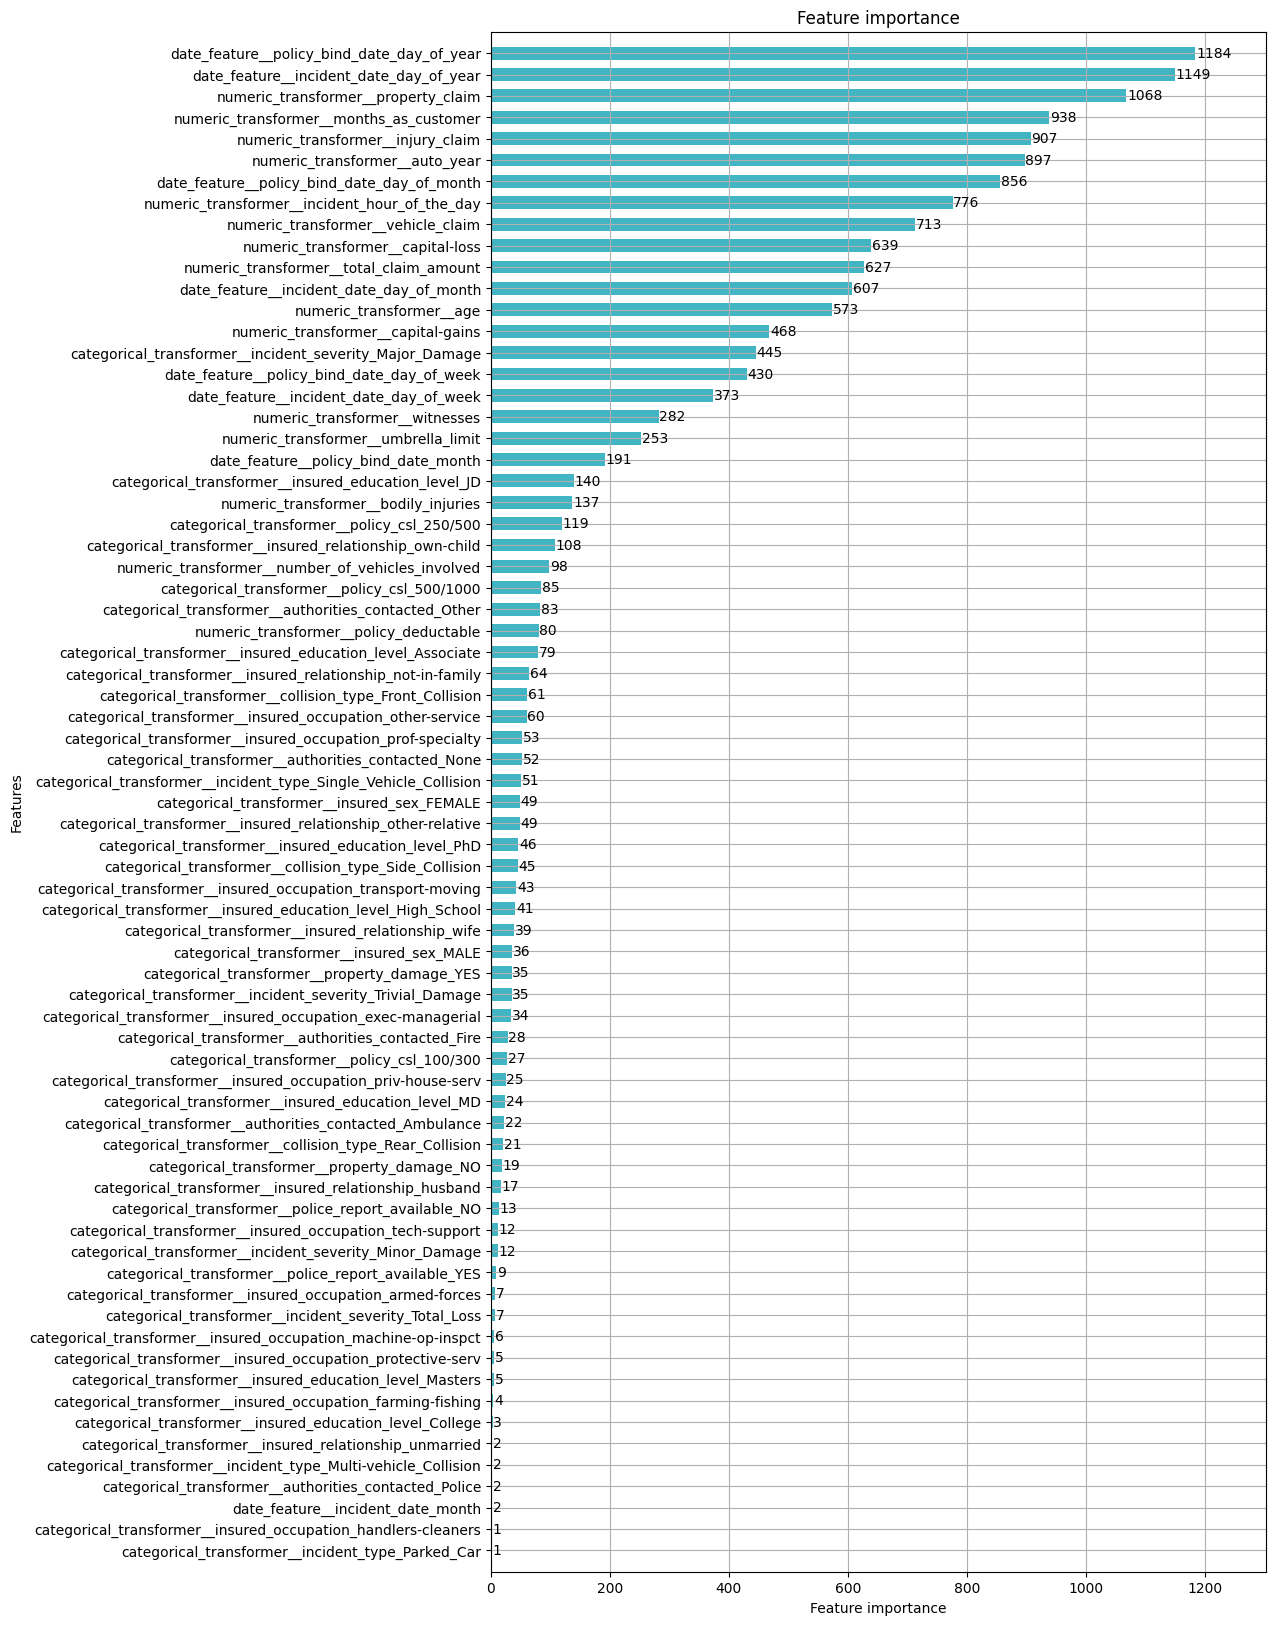

In [36]:
ax = lightgbm.plot_importance(
    model.named_steps["classifier"],
    height=0.6,
    figsize=(10, 20),
    color="#42b5c4",
)